# GPcounts on bulk dataset

Nuha BinTayyash, 2020

This notebook shows how to run [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) R package to normalize [fission yeast](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression data. Then, run two-samples test using GPcounts with negative binomial likelihood and compare it with Gaussian likelihood to find differentially expressed genes.

#### load fission yeast dataset

In [1]:
library("fission")
data("fission")
counts <- SummarizedExperiment::assay(fission)
keep <- rowMeans(counts) >1
counts <- counts[keep,]
col_data <- fission@colData
write.csv(col_data, file = "../data/fission_col_data.csv")

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

#### normalize datset using DESeq2

In [2]:
library("DESeq2")
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = col_data,
                              design = ~ strain + minute + strain:minute)

dds <- estimateSizeFactors(dds)
normalized_counts<-counts(dds, normalized=TRUE)
dim(normalized_counts)
write.csv(normalized_counts, file = "../data/fission_normalized_counts.csv")

[1] 6459   36

#### Change R kernel to Python kernel

In [10]:
import numpy as np
import pandas as pd
import gpflow

In [11]:
filename = '../data/fission_normalized_counts.csv'
Y = pd.read_csv(filename,index_col=[0])
X = pd.read_csv('../data/fission_col_data.csv',index_col=[0])
X = X[['minute']]

Fit some fission gene normalized data using GPcounts -- Two samples test

In [12]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot():
    plt.tick_params(labelsize='large', width=2)     
    #plt.ylabel('Gene Expression', fontsize=16)
    #plt.xlabel('Times', fontsize=16)
    c = 'royalblue'
    
    if model_index == 3:
        c = 'green'
    
    plt.plot(xtest, mean,color= c, lw=2) 
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),color=c,alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color=c, alpha=0.1)# two standard deviation
    else:
       
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,color=c,alpha=0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color=c,alpha=0.1)
    
    if test == 'Two_samples_test' and model_index == 1:
        plt.scatter(model.data[0][0:int(model.data[0].shape[0]/2)],model.data[1][0:int(model.data[0].shape[0]/2)], s=30, marker='o', color= 'royalblue',alpha=1.) #data    
        plt.scatter(model.data[0][int(model.data[0].shape[0]/2)::],model.data[1][int(model.data[0].shape[0]/2)::], s=30, marker='o', color= 'green',alpha=1.) #data

    else: 
        plt.scatter(model.data[0],model.data[1],s=30,marker = 'o',color=c,alpha=1.)
    
    
    if not(test == 'Two_samples_test' and model_index == 2):
        plt.show()
    

In [13]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
genes_name = ['SPAC11D3.01c']
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])
log_likelihoods = gp_counts.Two_samples_test(likelihood)
log_likelihoods

100%|██████████| 1/1 [00:09<00:00,  9.02s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio,Shared_model_time,model_1_time,model_2_time
SPAC11D3.01c,-230.95532,-120.988723,-105.931814,4.034783,0:00:02.584843,0:00:02.501210,0:00:03.924710


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


SPAC11D3.01c


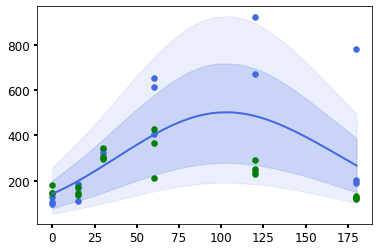

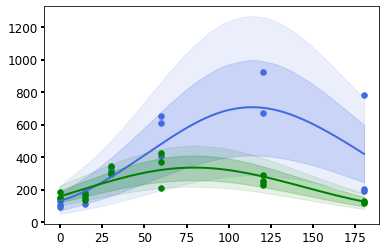

In [14]:
indexes = log_likelihoods.index.values # list of genes to be plotted 
test = 'Two_samples_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for mean,var,model in zip(params['means'][i],params['vars'][i],params['models'][i]):
        plot() 
        model_index = model_index + 1

In [15]:
likelihood = 'Gaussian'
log_likelihoods = gp_counts.Two_samples_test(likelihood)
log_likelihoods

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio,Shared_model_time,model_1_time,model_2_time
SPAC11D3.01c,-29.4808,-18.18272,-13.617617,0.0,0:00:00.233652,0:00:00.221429,0:00:00.214476


100%|██████████| 1/1 [00:00<00:00, 15.95it/s]


SPAC11D3.01c


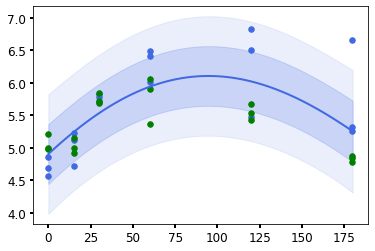

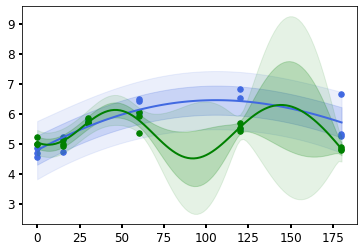

In [16]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1